# Export packages

In [48]:
import nltk
import re
import difflib
from nltk.tokenize import TweetTokenizer
import re
import difflib
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random #As of now only used for generating 100 random tweets for manual labelling
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report, roc_auc_score, roc_curve, recall_score, precision_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

## Reading data
### The Offensive Training Data

In [2]:
f = open("../data/raw/offensive/train_text.txt", 'r', encoding = "utf-8")
inputlist = [line for line in f]
f.close()

training_data, validation_data = inputlist[:len(inputlist)//2], inputlist[len(inputlist)//2:]

## Tokenizer as Function:

During the tokenization the code separate the tweets into sentences, which are cleared (emojis, not alphabetic characters are removed). For instance,  instead of "@user" it records "user". 

In [3]:
def tokenizer(tweets):
    """
    Function that takes a list of strings and returns the tokenized version of each string
    """
    #counter = 0
    #token_pat = re.compile(r'[\w@’#]+')
    token_pat = re.compile(r'\w+')
    skippable_pat = re.compile(r'\s+')

    non_white_space = re.compile(r'[^@’#\w\s]') #Finds characters that are not white_space nor word characters (nor @’#)
    #print("these are the tweets")
    #print(tweets)
    
    # Initialise lists
    tokens = []
    unmatchable = []

# Compile patterns for speedup
    token_pat = re.compile(r'\w+')

    tokenlist = []
    for i in tweets:
        #counter = counter + 1
        #print(counter)
        #tokens = []
        #unmatchable = []
        line = i
        #print("this is i: ",i)
        while line:
            #print("this is the line")
            #print(line)
            skippable_match = re.search(skippable_pat, line)
            if skippable_match and skippable_match.start() == 0:
                line = line[skippable_match.end():]
            else:
                token_match = re.search(token_pat, line)
                #print("tokens_match")
                #print(token_match)
                #print(token_match.start())
                if token_match and token_match.start() == 0:
                    #print("\nAPPEND IS RUNNING\n")
                    #print(line[:token_match.end()])
                    tokens.append(line[:token_match.end()])
                    line = line[token_match.end():]
                else:
                    unmatchable_end = len(line)
                    if skippable_match:
                        unmatchable_end = skippable_match.start()
                    if token_match:
                        unmatchable_end = min(unmatchable_end, token_match.start())
                    unmatchable.append(line[:unmatchable_end])
                    line = line[unmatchable_end:]
        tokenlist.append(tokens)
        tokens = []
    return(tokenlist)

In [4]:
token_tweets = tokenizer(training_data)
#print(token_tweets[0])
#print(token_tweets[1])
#[print(*i) for i in token_tweets]

['user', 'Bono', 'who', 'cares', 'Soon', 'people', 'will', 'understand', 'that', 'they', 'gain', 'nothing', 'from', 'following', 'a', 'phony', 'celebrity', 'Become', 'a', 'Leader', 'of', 'your', 'people', 'instead', 'or', 'help', 'and', 'support', 'your', 'fellow', 'countrymen']
['user', 'Eight', 'years', 'the', 'republicans', 'denied', 'obama', 's', 'picks', 'Breitbarters', 'outrage', 'is', 'as', 'phony', 'as', 'their', 'fake', 'president']


In [6]:
#TweetTokenizer Initialisation
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
j = 0
for i in training_data: 
    temp = i
    diff = difflib.context_diff(tknzr.tokenize(i),token_tweets[j])
    #print("".join(diff), end = "")
    #print(i,"tknzr:",tknzr.tokenize(i),"\ntokenlist:",token_tweets[j],"\n")
    j+=1

### Corpus size of Offensive and sentiment training sets respectively:

In [7]:
%%bash
wc ../data/raw/offensive/train_text.txt
wc ../data/raw/sentiment/train_text.txt

  11916  262370 1540990 ../data/raw/offensive/train_text.txt
  45615  877516 5015644 ../data/raw/sentiment/train_text.txt


<b>Offensive:</b> 11916 lines/tweets, 262370 words <br>
<b>Sentiment:</b> 35615 lines/tweets, 877516 words

### Running tokenizer function on offensive and sentiment training data to get token count right

In [8]:
with open("../data/raw/offensive/train_text.txt", "r",  encoding = "utf-8",) as f:
    offensive_raw = [line for line in f]

with open("../data/raw/sentiment/train_text.txt", "r",  encoding = "utf-8",) as f:
    sentiment_raw = [line for line in f]


<i>Below line takes a time

In [11]:
offensive_tokens = tokenizer(offensive_raw)
sentiment_tokens = tokenizer(sentiment_raw)

Below the top 10 tokens are collected

In [12]:
#from https://stackoverflow.com/questions/45019607/count-occurrence-of-a-list-in-a-list-of-lists
off_uniq = pd.Series(offensive_tokens).explode().value_counts()
sent_uniq = pd.Series(sentiment_tokens).explode().value_counts()

print("Offensive dataset, top 10 tokens:","\n",off_uniq[:10],"\n")
print("Sentiment dataset, top 10 tokens:","\n",sent_uniq[:10])

#Turning above pd.series into dataframes, for ease of use later
#Transformation found at:https://stackoverflow.com/questions/40224319/pandas-series-to-dataframe-using-series-indexes-as-columns
off_uniq = off_uniq.to_frame().reset_index()
sent_uniq = sent_uniq.to_frame().reset_index()

#Renaming columns in dataframes
off_uniq.columns = ["token","count"]
sent_uniq.columns = ["token","count"]

Offensive dataset, top 10 tokens: 
 user    29812
the      7271
is       5656
to       5472
a        4582
and      4106
you      3683
of       3347
are      3076
I        3075
dtype: int64 

Sentiment dataset, top 10 tokens: 
 the     34873
to      20673
user    16840
I       15273
in      13130
on      12573
a       12202
and     12015
of      10683
for      9669
dtype: int64


### Tokens and their counts:

In [31]:
%%bash
tr ' ' '\n' <../data/interim/tokenized/offensive_tokens.txt | sort | uniq -c | sort -r > ../data/interim/uniq/offensive_uniq.txt
tr " " "\n" <../data/interim/tokenized/sentiment_tokens.txt | sort | uniq -c | sort -r > ../data/interim/uniq/sentiment_uniq.txt

#### The ten most frequent tokens in "offensive_training":

Through Bash the top tokens are highlighted 

In [32]:
%%bash
head ../data/interim/uniq/offensive_uniq.txt

  29578 '@user',
  15538 '.',
   7271 'the',
   5601 'is',
   5466 'to',
   4580 'a',
   4106 'and',
   3748 '.'
   3595 'you',
   3520 '"',


#### The ten most frequent tokens in "sentiment_training":

In [15]:
%%bash
head ../data/interim/uniq/sentiment_uniq.txt

  51425 '.',
  34858 'the',
  22327 '"',
  20661 'to',
  19345 "'",
  17707 ',',
  15497 '@user',
  15270 'I',
  13339 '!',
  13113 'in',


### type/token ratio

In [35]:
#Types == Amount of different Tokens in dataset
off_types = len(off_uniq["token"])
sent_types = len(sent_uniq["token"])
print("Offensive Types: {}\nSentiment types: {}\n".format(off_types,sent_types))

#Tokens == Amount of all "Words" in dataset
off_token_amount = off_uniq["count"].sum()
sent_token_amount = sent_uniq["count"].sum()
print("Offensive tokens, amount: {}\nSentiment tokens, amount: {}\n".format(off_token_amount, sent_token_amount))

#Type/token ratio (=ttratio)
off_ttratio = off_types/off_token_amount
sent_ttratio = sent_types/sent_token_amount
print("Offensive type/token ratio: {:.4f}\nSentiment type/token ratio: {:.4f}".format(off_ttratio, sent_ttratio))

Offensive Types: 22915
Sentiment types: 55959

Offensive tokens, amount: 267520
Sentiment tokens, amount: 906399

Offensive type/token ratio: 0.0857
Sentiment type/token ratio: 0.0617


#### Tokens that only occur 1, 2 or 3 times
<ul>
    <li>Things like Hashtags and emojis are prevalent, but they, more importantly, contain most of the types/vocabulary</li>
    <li>Tokens that occur only once make up 58% of the types in both datasets!</li>
</ul>

In [36]:
print("Offensive types w. freq. 1 divided by total types: {:.2f}".format(len(off_uniq.loc[off_uniq["count"]==1])/off_types*100))
print("Sentiment types w. freq. 1 divided by total types: {:.2f}".format(len(sent_uniq.loc[sent_uniq["count"]==1])/sent_types*100))

Offensive types w. freq. 1 divided by total types: 56.13
Sentiment types w. freq. 1 divided by total types: 56.32


Amount of types showing up x times in the offensive dataset (e.g 14000 tokens only showing up once, and so on)
500 Most common tokens skipped, to make plot visible

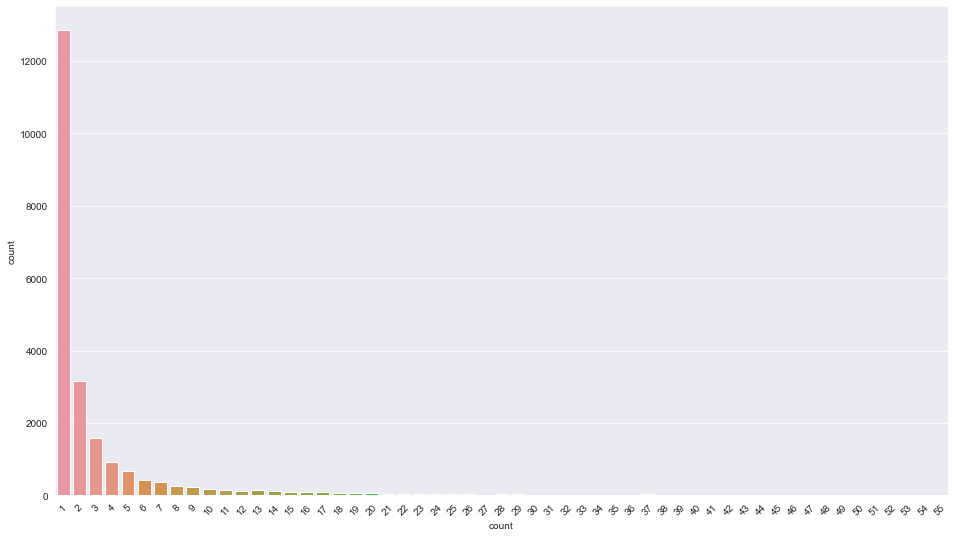

In [37]:
fig, ax = plt.subplots(figsize=(16,9))
sns.countplot(x="count", data=off_uniq[500:]) #Sns counts the type frequency of each word, and plots it
sns.set_style("darkgrid")
ax.tick_params('x',rotation=45, labelsize = 10) #xlabels are rotated 45 degrees and made bigger

### Noticable difference in the two datasets

<ul>
    <li>Big difference in size, sentiment dataset over twice the amount of tokens (=library twice the size)</li>
    <li>otherwise quite similar, in both sets the percentage of the vocabulary made up of tokens w. frq. 1 is 58%</li>
    <ul><li>Both datasets also seem to follow Zipf's law (see below graphs)</li>
    </ul>
</ul>
    

### Corpus Statistics Consistent with Zipf's law?

Log-log plot of the rank of token frequency against against the frequency in the offensive dataset

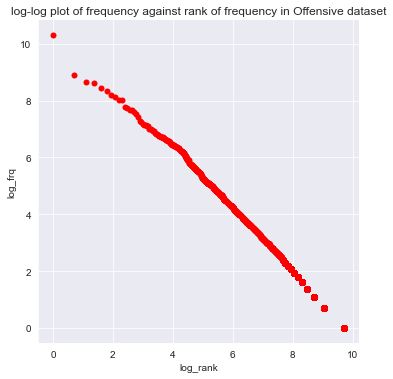

In [38]:
off_uniq["log_frq"] = np.log(off_uniq["count"])
off_uniq["log_rank"] = np.log(off_uniq["count"].rank(ascending=False))
sns.relplot(x="log_rank",y="log_frq", data=off_uniq, color="red", edgecolor=(0.2,0,0,0.01)).set(title=
                "log-log plot of frequency against rank of frequency in Offensive dataset")
plt.show()

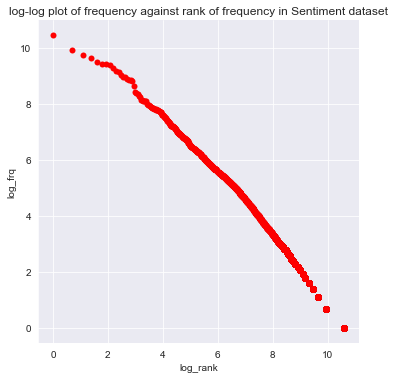

In [39]:
sent_uniq["log_frq"] = np.log(sent_uniq["count"])
sent_uniq["log_rank"] = np.log(sent_uniq["count"].rank(ascending=False))
sns.relplot(x="log_rank",y="log_frq", data=sent_uniq, color="r", edgecolor=(0.2,0,0,0.01)).set(title=
                "log-log plot of frequency against rank of frequency in Sentiment dataset")
plt.show()

<b>As seen in the above plots, both datasets seem consistent with Zipf's law</b>

## Task 3: Manual Annotation & Inter-user Agreement

### Generating 100 random tweets for manual annotation

In [40]:
random.seed(42) #Seeded for consistency
random_tweets = random.sample(list(enumerate(sentiment_raw)),100)
rtweet_index = [i[0] for i in random_tweets]

# #File-generation is commented out, as the randomness is seeded, thus Making the same "Random" file every time
# with open("../data/interim/random_tweets.txt","w", encoding="utf-8") as f:
#     [f.write(str(i[1])+"\n") for i in random_tweets]

In [41]:
sent_label = pd.read_csv('../data/raw/sentiment/train_labels.txt',header=None)
sent_raw = pd.read_csv("../data/raw/sentiment/train_text.txt",header=None, sep="\n",quoting=3)

### Putting the manually annotated labels into a single dataframe

In [43]:
man_labels = pd.read_csv("../data/interim/manual_annotation/all_combined.csv", delimiter=",") #All manual labels
man_labels = man_labels.iloc[:,:-1] #Not using the _A0_value column from the file
display(man_labels) #The manually annotated labels, put into a dataframe

same_label = man_labels.eq(man_labels.iloc[:,0], axis=0).all(1) #Finding where all annotators agree on a label
display(same_label)
print("# of equal labels:",np.sum(same_label))
obs_agreement = np.sum(same_label)/len(man_labels.iloc[:,0])
print("observed agreement:",obs_agreement)

,anno_1,anno_2,anno_3,anno_4
0,1,1,1,1
1,2,1,1,1
2,2,2,2,2
3,0,0,0,0
4,0,1,2,2
...,...,...,...,...
95,0,2,2,0
96,0,2,2,2
97,1,1,2,1
98,1,1,1,1


0      True
1     False
2      True
3      True
4     False
      ...  
95    False
96    False
97    False
98     True
99    False
Length: 100, dtype: bool

# of equal labels: 34
observed agreement: 0.34


### Calculating Chance-corrected agreement

In [24]:
#Formatting manual label answers to calculate Scott's pi, Fleiss' kappa with nltk.agreement
tweets_len = len(man_labels.iloc[:,0])
formatted_answers = [] #Formatting of only the manually annotated data
for column in range(len(man_labels.columns)):
    for tweet_num in range(tweets_len):
        formatted_answers.append([column+1,tweet_num,man_labels.iloc[tweet_num,column]])

#adding the "True" labels to all_formatted:
all_formatted = formatted_answers.copy() #Formatting of BOTH the manually annotated data AND the "True" Annotation of the data
true_label_list = list(sent_label.iloc[rtweet_index][0])
for i in range(tweets_len):
    all_formatted.append([len(man_labels.columns)+1,i,true_label_list[i]])
    
print("lenght of formatted_answers:",len(formatted_answers))
print("length of all_formatted:",len(all_formatted)) #should be 100 characters longer than the above

lenght of formatted_answers: 400
length of all_formatted: 500


#### Chance-corrected for just the manual labels

The inter-annotator agreement values are almost 0.4, which can be decided as fair or moderate

In [25]:
"""
Note that in the nltk.agreement documentation: https://www.nltk.org/_modules/nltk/metrics/agreement.html
the returned value is the chance-corrected agreement, not just A_e.
"""
ratingtask = agreement.AnnotationTask(data=formatted_answers)
print("Scott's pi: {:.4f}\nCohen's kappa: {:.4f}\nFleiss' kappa: {:.4f}".format(ratingtask.pi(),ratingtask.kappa(),ratingtask.multi_kappa()))


Scott's pi: 0.3962
Cohen's kappa: 0.3950
Fleiss' kappa: 0.3968


#### Chance-corrected for both the manual labels AND the "true" labels

In [26]:
all_label_rating = agreement.AnnotationTask(data=all_formatted)
print("Scott's pi: {:.4f}\nCohen's kappa: {:.4f}\nFleiss' kappa: {:.4f}".format(all_label_rating.pi(),all_label_rating.kappa(),all_label_rating.multi_kappa()))


Scott's pi: 0.3911
Cohen's kappa: 0.3905
Fleiss' kappa: 0.3918


### Showing the tweets with agreeing/disagreeing manual labels for later discussion, saved to file

In [27]:
same_label[same_label==False]
manual_tweets = sent_raw.loc[rtweet_index]

#tweets labels disagree on
annotation_disagree = manual_tweets.iloc[np.where(same_label==False)]
display(annotation_disagree[:10])#Showing the 10 first tweets with disagreeing manual annotation

#tweets labels agree on
annotation_agree = manual_tweets.iloc[np.where(same_label==True)]

# File creation commented out
# annotation_disagree.to_csv("../data/interim/man_anno_disagree.txt", header=None, index=False)
# annotation_agree.to_csv("../data/interim/man_anno_agree.txt", header=None, index=False)

man_labels[same_label==True]["anno_1"][:10]

,0
7296,Convenient location to the Georgia Dome: This ...
16049,In bed in Plymouth hotel for the last night of...
14628,Former Florida Gov. Jeb Bush said Thursday tha...
6717,Exciting weekend. Kitchen being fitted today F...
44348,Will the PM stand by and watch his colleagues ...
35741,@user take Niall's guitar and play on stage at...
5697,When you're sick of waiting for a book to come...
27651,"""12 Ways June Squibb Is the New Jennifer Lawre..."
2082,i want Michelle Obama to be president with Mic...
1952,@user @user As far as I know Rick Perry hasn't...


0     1
2     2
3     0
6     2
11    1
15    1
16    2
18    2
19    1
20    2
Name: anno_1, dtype: int64

# Calculating the Observed Agreement result of the manual annotation

During the manual annotation we found in case:
- Only 34% of the cases we totally agreed 34% 
- 43% of the cases one of us had different opinion
- 23% of the cases (this means 0.5 Observed Agreement result) we couldn't decide obviously the sentiment of the sentence

Text(0.5, 1.0, 'Observed Agreement results of manual annotation')

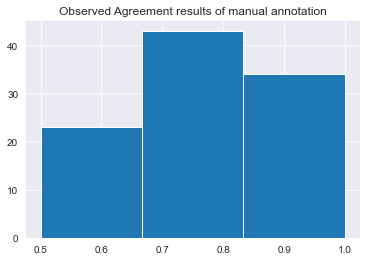

In [44]:
# hide errors
pd.options.mode.chained_assignment = None

man_labels.reset_index()
man_labels["AO"] = 1.1
for i in range(len(man_labels)):
    l = []
    rowData = man_labels.loc[ i , : ]
    l.append(rowData[0])
    l.append(rowData[1])
    l.append(rowData[2])
    l.append(rowData[3])
    occurence_count = Counter(l)
    same_counter = occurence_count.most_common(1)[0][1]
    res=occurence_count.most_common(1)[0][0]
    ao = same_counter/4
    #print(ao)
    man_labels["AO"][i] = ao
    #print("Variance of sample set is % s"  %(statistics.variance(l)),"AO number is : ", ao, "winner is :", res)
    None

plt.hist(man_labels["AO"], label='linear', bins=3)
plt.title('Observed Agreement results of manual annotation')